In [19]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

In [20]:
tf.__version__

'2.17.0'

In [21]:
base_path = f"{os.environ['HOME']}/lectures"
data_path = f"{base_path}/data/processed/netcdf/temperature_1000hPa"
results_path = f"{base_path}/results/temperature_1000hPa"

In [22]:
# Exemplo de função para calcular a média das imagens de temperatura
def calculate_image_mean(data):
    # data tem a forma (tempo, latitude, longitude)
    return np.mean(data, axis=(1, 2))  # Média sobre latitude e longitude

In [23]:
# Preparar os dados para LSTM
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [24]:
ds_train = xr.open_dataset(f"{data_path}/temperature_1000hPa_2019_train.nc")['t'].values
ds_train.shape

(8760, 49, 59)

In [25]:
# Definir os parâmetros do modelo
n_steps_in = 24  # Usar as médias das últimas 24 horas
n_steps_out = 3  # Prever t+1, t+2, t+3

means = calculate_image_mean(ds_train)
X_data, y_data = create_sequences(means, n_steps_in, n_steps_out)
# Redimensionar para [samples, timesteps, features] que é o formato esperado pela LSTM
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))
X_data.shape, y_data.shape

((8734, 24, 1), (8734, 3))

In [26]:
input_shape = (n_steps_in, 1)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(n_steps_out))  # Saída para t+1, t+2, t+3

/home/adriano/lectures/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# import matplotlib.pyplot as plt

# # Simular as primeiras 3000 steps para visualização do comportamento
# steps = 3000
# lr_values = [lr_schedule(step) for step in range(steps)]

# # Plotar o comportamento do Cosine Decay com Restarts
# plt.plot(range(steps), lr_values)
# plt.title('Cosine Decay with Restarts Learning Rate Schedule')
# plt.xlabel('Training steps')
# plt.ylabel('Learning Rate')
# plt.show()


In [28]:
# Definir o CosineDecayRestarts
initial_learning_rate = 0.01  # Define a taxa de aprendizado inicial
first_decay_steps = 5      # Número de passos para o primeiro ciclo
t_mul = 2.0                   # Fator de multiplicação para o número de passos em cada ciclo
m_mul = 1.0                   # Fator multiplicador para o learning rate após cada restart (normalmente 1.0)
alpha = 0.0                   # Valor mínimo da taxa de aprendizado

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=t_mul,   # Aumenta o número de passos em cada ciclo
    m_mul=m_mul,   # Multiplicador para o learning rate após cada reinício
    alpha=alpha    # Limite inferior para a taxa de aprendizado
)

# Aplicar o scheduler no otimizador (por exemplo, Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Agora, compile o modelo com o otimizador que usa o scheduler
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,103 (51.18 KB)

 Trainable params: 13,103 (51.18 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{results_path}/lstm_{{epoch:03d}}_{{val_loss:.2f}}.keras",
        save_best_only=True,
        monitor='val_loss', 
        mode='min'
    )
]

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6987, 24, 1), (6987, 3), (1747, 24, 1), (1747, 3))

In [31]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2184.9485 - val_loss: 13.6172
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5126 - val_loss: 1.9965
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8348 - val_loss: 1.6863
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5420 - val_loss: 1.1819
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1521 - val_loss: 1.0477
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0464 - val_loss: 0.9192
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9795 - val_loss: 0.7395
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7696 - val_loss: 0.7671
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6854 - val_loss: 0.5300
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5692 - val_loss: 0.4938
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4861 - val_loss: 0.4633
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/

In [32]:
# saving history
with open(f"{results_path}/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# saving model
model.save(f"{results_path}/lstm_best_model.h5")

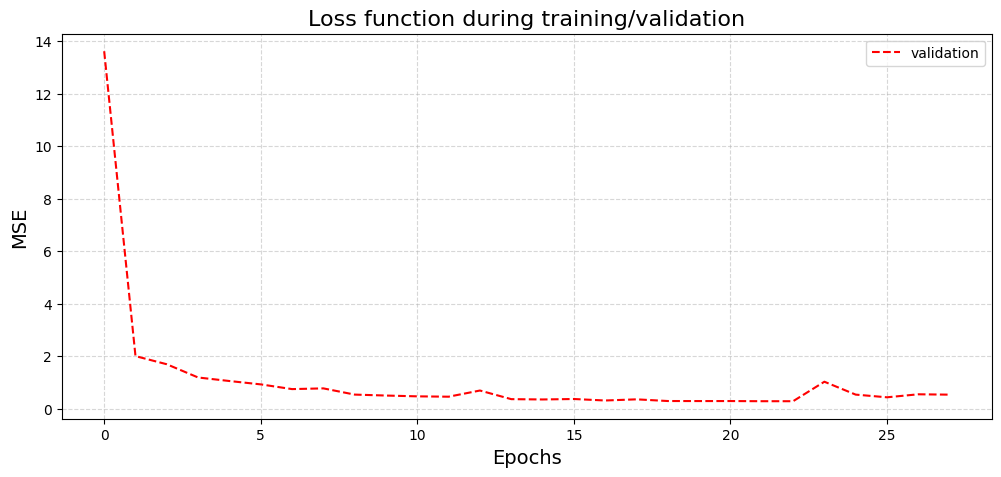

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(history.history['val_loss'], color='red', ls='--', label='validation')
ax.set_title('Validation loss function', fontsize=16)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.legend()

In [34]:
ds_test = xr.open_dataset(f"{data_path}/temperature_1000hPa_2020_test.nc")['t'].values
means = calculate_image_mean(ds_test)
X_test, y_test = create_sequences(means, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test.shape, y_test.shape

((8758, 24, 1), (8758, 3))

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error (MSE): 0.2851682605788422
Mean Absolute Error (MAE): 0.38282641408998624


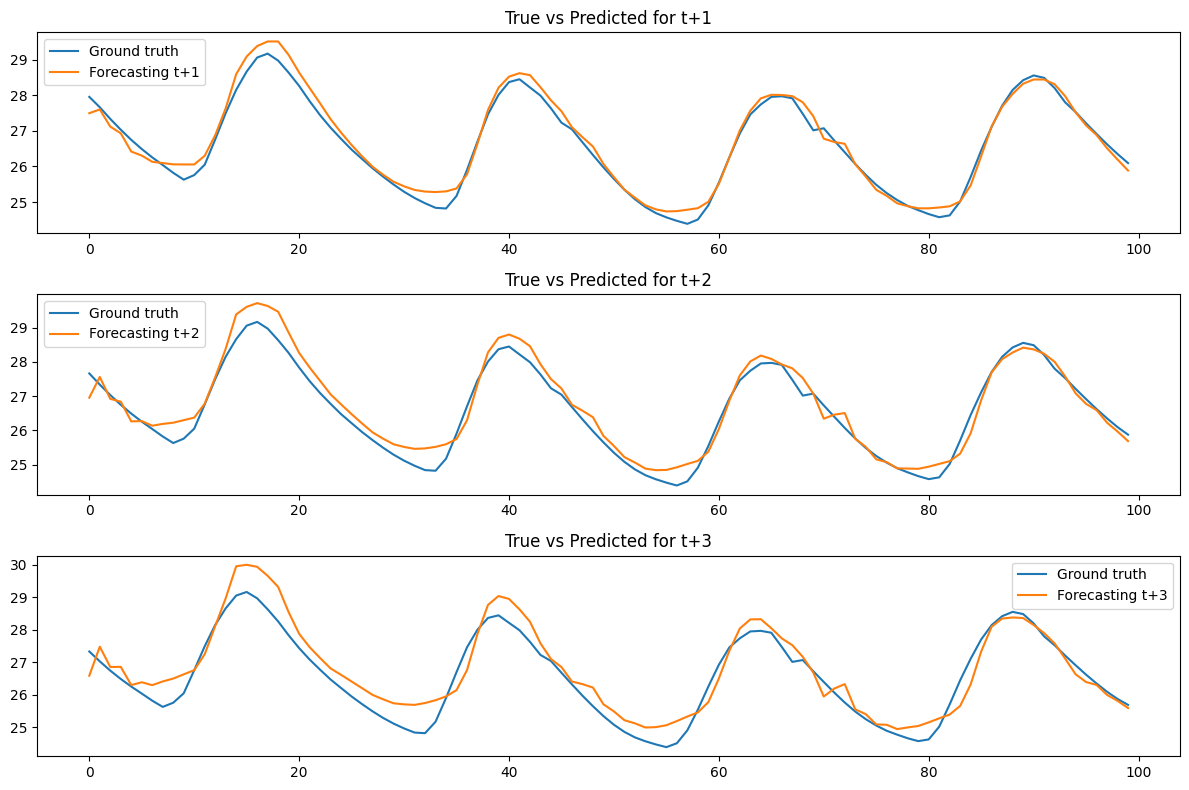

In [35]:
y_pred = model.predict(X_test)

# Calcular métricas de erro
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Visualizar algumas previsões e valores reais para t+1, t+2, t+3
# Por exemplo, vamos comparar as primeiras 10 previsões e os valores reais
n = 100
plt.figure(figsize=(12, 8))

for i in range(n_steps_out):  # Para t+1, t+2, t+3
    plt.subplot(3, 1, i+1)
    plt.plot(y_test[:n, i], label=f"Ground truth")
    plt.plot(y_pred[:n, i], label=f"Forecasting t+{i+1}")
    plt.legend()
    plt.title(f"True vs Predicted for t+{i+1}")

plt.tight_layout()
plt.show()


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


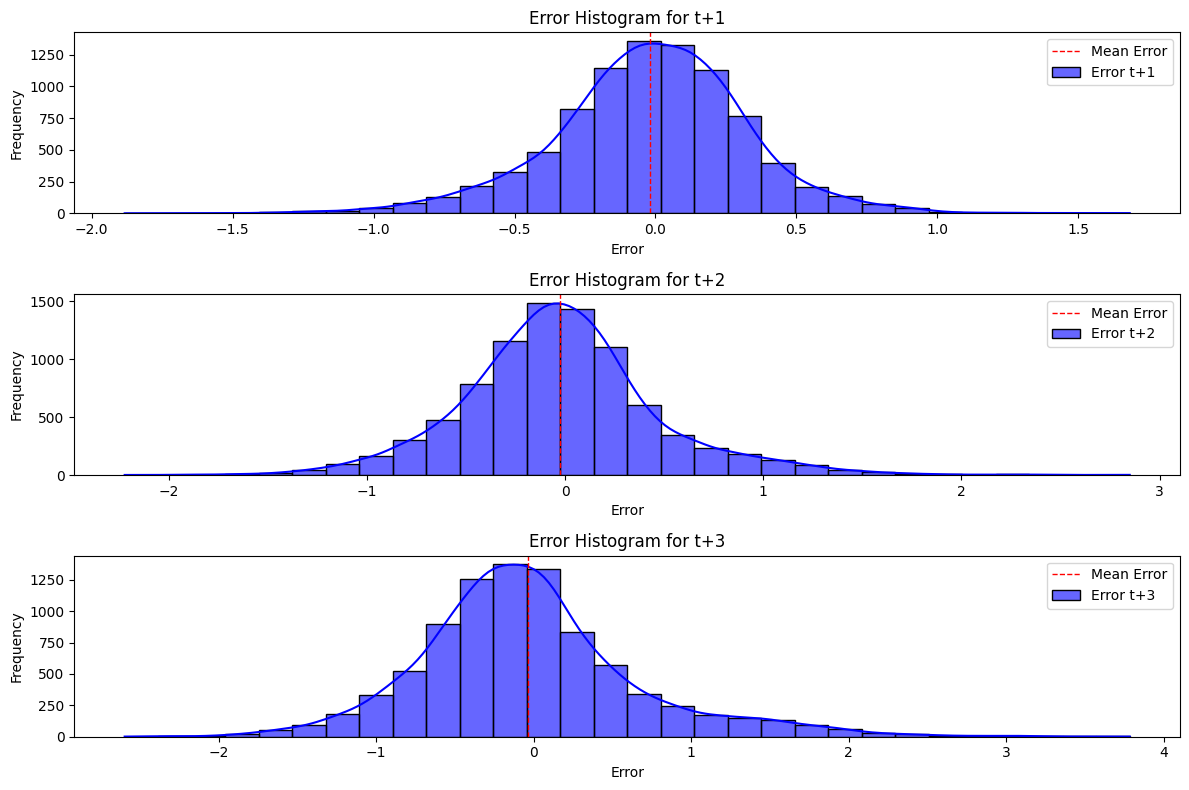

In [36]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliação por histograma (distribuição dos erros) com seaborn e teste de hipótese
plt.figure(figsize=(12, 8))

for i in range(n_steps_out):
    plt.subplot(3, 1, i+1)
    
    # Calculando o erro de previsão (erro = valor real - valor previsto)
    errors = y_test[:, i] - y_pred[:, i]
    
    # Plotar histograma dos erros com seaborn
    sns.histplot(errors, bins=30, kde=True, color='blue', alpha=0.6, label=f'Error t+{i+1}')
    
    # Adicionar linha da média dos erros
    plt.axvline(errors.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean Error')
    
    plt.legend()
    plt.title(f'Error Histogram for t+{i+1}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
